# Regresor logístico

Notebook escrito por Multivacs en 2025.  
Como referencia [logistic.ipynb](https://colab.research.google.com/github/jaspock/me/blob/main/docs/materials/transformers/assets/notebooks/logistic.ipynb) de Juan Antonio Pérez.

Este notebook es parte de la serie [Introducción a las Redes Neuronales](https://multivacs.com/tags/intro-nn/).



## Instalación de dependencias

Instalamos las librerías necesarias para ejecutar el código

In [ ]:
%%capture
%pip install matplotlib numpy torch scikit-learn

## Establecemos semilla

Configuramos una semilla inicial para hacer que los resultados sean reproducibles. Esto es para todas las funciones que utilicen métodos aleatorios, tratar de obtener los mismos resultados independientemente de la ejecución.

Digo tratar ya que aún así, es posible que torch utilice métodos no deterministas para la multiplicación de matrices, por lo que no se garantiza la reproducibilidad, aunque serán muy parecidos.

In [1]:
import os
# establecemos esta variable de entorno previamente a importar pytorch para evitar operaciones no deterministas en GPU
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)

set_seed(42)

## Generamos datos sintéticos

Vamos a generar un dataset de manera aleatoria un vector de dos elementos por cada clase, utilizando una distribución normal.

El siguiente código genera datos para las dos clases utilizando `scikit-learn` y su función `sklearn.datasets.make_blobs`.  
Esta función devuelve una tupla con los datos generados y la correspondiente etiqueta (en nuestro caso, 0 y 1).

Xn.shape = (100, 2)
yn.shape = (100,)
Xn[:3] = [[3.47323762 3.92717109]
 [0.16078248 1.69078762]
 [1.08122878 3.97348612]]
yn[:3] = [1 0 1]


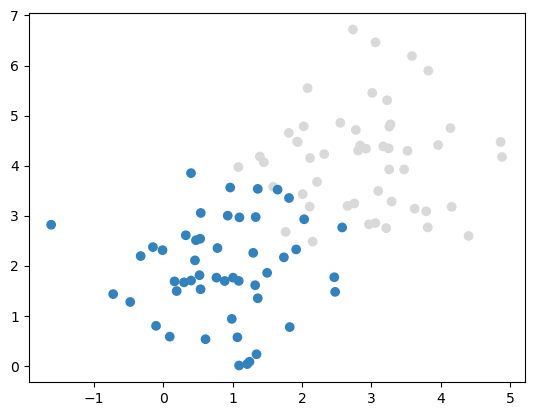

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

class_centers = [[1,2], [3,4]]
samples = 100  # número de muestras por clase
features = 2  # dimensión de las muestras (num columnas)

Xn, yn = make_blobs(n_samples=samples, centers=class_centers, cluster_std=1, n_features=features, random_state=42)

print(f"Xn.shape = {Xn.shape}")
print(f"yn.shape = {yn.shape}")
print(f"Xn[:3] = {Xn[:3]}")
print(f"yn[:3] = {yn[:3]}")

plt.scatter(Xn[:,0], Xn[:,1], c=yn, cmap='tab20c')

## Inicializar tensores

Como sabrás, en cuanto a computación, las CPUs están diseñadas para uso general, llevando a cabo tareas diversas y normalmente, de manera secuencial (en fila).  
Mientras que las GPUs son hardware dedicado a una tarea muy específica, como es el procesamiento y cálculo en paralelo, haciéndolos muy eficientes para realizar tareas simultáneas como el entrenamiento de modelos de deep learning.

Por tanto, vamos a pasar de vectores NumPy (CPU-efficient) a tensores PyTorch (GPU-optimized).  
Para ello, utilizaremos la función nativa de PyTorch `torch.from_numpy`, que recoge como input un vector NumPy y lo transforma a un objeto de tipo `torch.Tensor`.

Como dato adicional, NumPy utiliza doble precisión (FP64) por defecto, mientras que PyTorch usa 32 bits, ya que las GPUs son más rápidas en precisión simple y la diferencia en precisión es normalmente insignificante. Por eso, convertimos primero el vector NumPy de 64 a 32 bits.

In [3]:
import numpy as np
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"  # comprobamos si tenemos gpu disponible
print(f'Usando {device}')

X = torch.from_numpy(np.float32(Xn)).to(device)
y = torch.from_numpy(np.float32(yn)).to(device)

print(f"type(X) = {type(X)}, type(y) = {type(y)}")
print(f"X[:3] = {X[:3]}")
print(f"y[:3] = {y[:3]}")

Usando cuda:0
type(X) = <class 'torch.Tensor'>, type(y) = <class 'torch.Tensor'>
X[:3] = tensor([[3.4732, 3.9272],
        [0.1608, 1.6908],
        [1.0812, 3.9735]], device='cuda:0')
y[:3] = tensor([1., 0., 1.], device='cuda:0')


## Dividir los datos en entrenamiento y test

En Machine Learning solemos diferenciar entre el conjunto de datos que utilizaremos para entrenar el modelo, y aquél usado para comprobar su rendimiento.  
Esto es para poder ver cuál es la capacidad de generalización de nuestro modelo, ya que lo interesante no es que el modelo se aprenda todas las respuestas de nuestro listado de memoria (overfitting), sino que sea capaz de dada una entrada que previamente no ha visto, poder inferir la probabilidad de pertenencia a una clase.

Adicionalmente, se crea un tercer subconjunto de los datos dedicado a validación. Para entender su función, digamos que es como una manera de ir comprobando periódicamente cada x iteraciones, si el modelo ha sido capaz de mejorar o no respecto a las iteraciones previas. Esto es para tratar de forzar que el modelo pare cuando haya dejado de mejorar en su entrenamiento y evitar el sobreentrenamiento.

Para hacer la división crearemos una máscara poniendo a 0 aquellas muestras dedidacadas a entreno, a 1 las de test y a 2 las de validación.

In [4]:
mask = torch.zeros(X.shape[0], dtype=int).to(device)
mask[::3] = 1  # cada 3 elementos lo utilizamos como test (1)

# De los restantes, tomamos algunos como validación (2), cada quinto de los no test
mask[(mask == 0).nonzero().squeeze()[::5]] = 2  

X_train, y_train = X[mask == 0], y[mask == 0]
X_test, y_test = X[mask == 1], y[mask == 1]
X_val, y_val = X[mask == 2], y[mask == 2]

print(f"X_train.shape = {X_train.shape}; y_train.shape = {y_train.shape}")
print(f"X_test.shape = {X_test.shape}; y_test.shape = {y_test.shape}")
print(f"X_val.shape = {X_val.shape}; y_val.shape = {y_val.shape}")

X_train.shape = torch.Size([52, 2]); y_train.shape = torch.Size([52])
X_test.shape = torch.Size([34, 2]); y_test.shape = torch.Size([34])
X_val.shape = torch.Size([14, 2]); y_val.shape = torch.Size([14])


## Funciones auxiliares

Definimos las siguientes funciones que serán utilizadas durante el entrenamiento e inferencia del modelo:

- `regressor`: inicializa y devuelve los parámetros aprendibles (pesos y sesgo). Hay varias estrategias para inicializar estos parámetros, por ahora lo iniciaremos de manera aleatoria.
- `sigmoid`: devuelve un tensor en el que cada elemento es la sigmoide del elemento correspondiente del tensor de entrada.
- `forward`: devuelve la salida del regresor logístico.
- `binary_cross_entropy`: devuelve la función de pérdida de entropía cruzada, dado el vector de predicciones y la correspondiente salida esperada.

In [5]:
def regressor(size):
    weights = torch.rand(size, dtype=torch.float32).to(device)
    bias = torch.rand(1, dtype=torch.float32).to(device)
    return weights, bias

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def forward(X, weights, bias):
    return sigmoid(torch.matmul(X,weights) + bias)

def binary_cross_entropy(y_truth, y_pred):
    m = 1 / y_truth.shape[0]  # y_truth.shape[0] es el tamaño del mini-batch
    return -m * (y_truth * torch.log(y_pred) +
                    (1 - y_truth) * torch.log(1 - y_pred)).sum()

## Entrenando el modelo

Estamos listos para entrenar nuestro modelo para hacer clasificación de dos clases. El proceso de entrenamiento lo establecemos en la función `train`, que recibe como entrada el mini-batch de datos, la salida esperada, los parámetros de peso y bias, el learning rate, número de pasos a realizar, y el número de pasos en los que se evalúa el modelo para logging y comprobar con el conjunto de validación si mejora.

La función devuelve el vector de pesos y bias aprendidos, y el error tras el último paso de entrenamiento.

In [9]:
def loss_backward(y_truth, y_pred, X):
    '''
    Calcula el gradiente.
    '''
    err = (y_pred - y_truth)
    grad_w = (1 / y_truth.shape[0]) * torch.matmul(err, X)
    grad_b = (1 / y_truth.shape[0]) * torch.sum(err)
    return grad_w, grad_b

def optimizer_step(weights, bias, grad_w, grad_b, lr=0.01):
    '''
    Actualiza los parámetros del modelo.
    '''
    weights = weights - lr * grad_w
    bias = bias - lr * grad_b
    return weights, bias


def train(X, y_truth, X_val, y_val, weights, bias, lr=0.01, training_steps=1000, valid_steps=100, patience=10):
    '''
    Entrena el modelo y detiene el entrenamiento si la pérdida de validación no merjora después
    de 'patience' iteraciones.
    '''
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for i in range(training_steps):
        y_pred = forward(X, weights, bias)
        grad_w, grad_b = loss_backward(y_truth, y_pred, X)
        weights, bias = optimizer_step(weights, bias, grad_w, grad_b, lr)

        # Cada 'valid_steps' iteraciones evaluamos en validación
        if i % valid_steps == 0:
            # Calculamos las pérdidas de train y val
            train_loss = binary_cross_entropy(y_truth, y_pred).item()
            y_pred_val = forward(X_val, weights, bias)
            val_loss = binary_cross_entropy(y_val, y_pred_val).item()
            # item() devuelve un escalar a partir de un tensor de un único valor 

            # Guardamos las pérdidas para las gráficas
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print (f'Step [{i}/{training_steps}], Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}')

            # Early stopping: si la pérdida de validación no mejora aumentamos el contador de paciencia
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Si no mejora, detenemos el entrenamiento
            if patience_counter >= patience:
                print(f'Early stopping en iteración {i}')
                break

    # Devolvemos vector de pesos y pérdidas
    return weights, bias, train_losses, val_losses


def visualize_training(train_losses, val_losses, valid_steps):
    plt.plot(range(0, len(train_losses) * valid_steps, valid_steps), train_losses, label='Training Loss')
    plt.plot(range(0, len(val_losses) * valid_steps, valid_steps), val_losses, label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.show()

Step [0/300], Train loss: 1.46, Val loss: 1.40
Step [10/300], Train loss: 0.93, Val loss: 0.88
Step [20/300], Train loss: 0.75, Val loss: 0.73
Step [30/300], Train loss: 0.71, Val loss: 0.70
Step [40/300], Train loss: 0.69, Val loss: 0.69
Step [50/300], Train loss: 0.66, Val loss: 0.67
Step [60/300], Train loss: 0.64, Val loss: 0.66
Step [70/300], Train loss: 0.63, Val loss: 0.65
Step [80/300], Train loss: 0.61, Val loss: 0.63
Step [90/300], Train loss: 0.59, Val loss: 0.62
Step [100/300], Train loss: 0.58, Val loss: 0.61
Step [110/300], Train loss: 0.57, Val loss: 0.60
Step [120/300], Train loss: 0.56, Val loss: 0.59
Step [130/300], Train loss: 0.55, Val loss: 0.58
Step [140/300], Train loss: 0.54, Val loss: 0.57
Step [150/300], Train loss: 0.53, Val loss: 0.56
Step [160/300], Train loss: 0.52, Val loss: 0.56
Step [170/300], Train loss: 0.51, Val loss: 0.55
Step [180/300], Train loss: 0.50, Val loss: 0.54
Step [190/300], Train loss: 0.49, Val loss: 0.53
Step [200/300], Train loss: 0.4

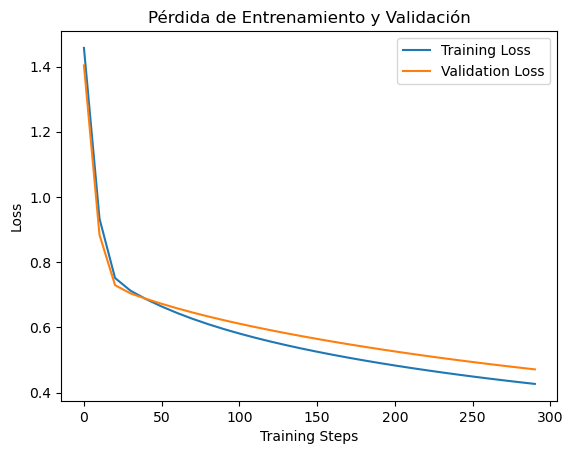

In [10]:
learning_rate = 0.05
training_steps = 300
valid_steps = 10
patience = 10

weights, bias = regressor(X_train.shape[1])
weights, bias, bn_train, bn_val = train(X_train, y_train, X_val, y_val, weights, bias,
                                    lr=learning_rate, training_steps=training_steps, valid_steps=valid_steps, patience=patience)

visualize_training(bn_train, bn_val, valid_steps)

## Evaluar el modelo (test)

Una vez tenemos el modelo entrenado, con sus pesos y bias, usamos el conjunto de test para medir su rendimiento

In [12]:
print(f'Regresor logístico aprendido: y = σ({weights[0]:.2f}*x1 + {weights[1]:.2f}*x2 + {bias.item():.2f})')
y_pred = forward(X_test, weights, bias)
loss = binary_cross_entropy(y_test, y_pred).item()
print(f'Binary cross-entropy en el conjunto de test: {loss:.2f}')
prediction = y_pred > 0.5 
correct = prediction == y_test
accuracy = (torch.sum(correct) / y_test.shape[0])*100
print (f'Precisión en el conjunto de test: {accuracy:.2f}%')

Regresor logístico aprendido: y = σ(0.83*x1 + 0.09*x2 + -1.28)
Binary cross-entropy en el conjunto de test: 0.36
Precisión en el conjunto de test: 91.18%


## Visualizamos la frontera de decisión

Por último dibujamos en una gráfica utilizando `matplotlib` la frontera de decisión del modelo, es decir, la línea (hiperplano) divisoria que separa las dos clases.

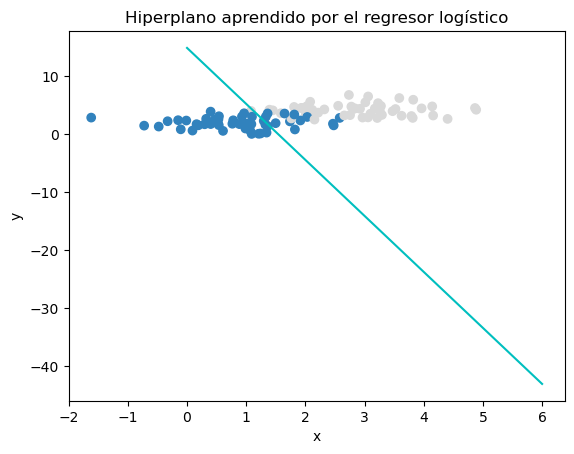

In [13]:
r = -weights[0].item() / weights[1].item()  # slope
t = -bias.item() / weights[1].item()  # intercept

plt.scatter(Xn[:,0], Xn[:,1], c=yn, cmap='tab20c')
plt.title(f"Hiperplano aprendido por el regresor logístico")
plt.xlabel("x")
plt.ylabel("y")
x_hyperplane = np.linspace(0,6,100)
y_hyperplane = r*x_hyperplane+t
plt.plot(x_hyperplane, y_hyperplane, '-c')  # -c means solid cyan line
plt.show()